<a href="https://colab.research.google.com/github/Dominika26/classification_tutorials_public/blob/main/TF_keras_adoption_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KLasyfikacja danych strukturalnych z wykorzystaniem Keras do definicji modelu i stworzenia modelu- celem jest określenie czy zwierzę zostanie adoptowane.


In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 

from tensorflow.keras import layers

In [ ]:
tf.__version__

'2.8.0'

**Łasowanie danych**

In [ ]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'
tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)


In [ ]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


Tworznie zmiennej docelowej- przetwarzam kolumnę adoption speed, gdzie 0 oznacza, że nie było adopcji, a 1, że była

In [ ]:
#czyli tutaj piszę, że jak 4, to 0, a w przeciwnym wypadku 1
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)
dataframe = dataframe.drop(columns = ['AdoptionSpeed', 'Description'])


In [ ]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


**Podział na zestaw treningowy, walidacyjny i testowy**

In [ ]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [ ]:
print(len(train), 'training samples')
print(len(val), 'validation examples')
print(len(val), 'test examples')

9229 training samples
1154 validation examples
1154 test examples


**Potok wejściowy za pomocą tf.data**
Konwersja zestawó danych na tf.data.Dataset, a następnie tasowanie i grupowanie 

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

używam funkckcji df_to_dataset, wywołując ją na danych uczących, sprawdzam format danych 

In [ ]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


Zestaw uczący zwraca słownik nazw kolumn (z DataFrame), które mapują wartości kolumn z wierszy.

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature', list(train_features.keys()))
print('A batch of ages', train_features['Age'])
print('A batch of targets', label_batch)

Every feature ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages tf.Tensor(
[[ 2]
 [ 5]
 [ 4]
 [ 3]
 [24]], shape=(5, 1), dtype=int64)
A batch of targets tf.Tensor([1 1 1 0 0], shape=(5,), dtype=int64)


**Warstwy przetwarzania wstępnego Keras**
- tf.keras.layers.Normalization : Wykonuje pod względem funkcji normalizację funkcji wejściowych.
- tf.keras.layers.CategoryEncoding : zamienia elementy kategorialne w liczbach całkowitych w reprezentacje jednoaktywne, wieloaktywne lub gęste tf-idf .
- tf.keras.layers.StringLookup : Zamienia wartości kategorii ciągów na indeksy liczb całkowitych.
- tf.keras.layers.IntegerLookup : Zamienia całkowite wartości kategoryczne na indeksy całkowite.

**Kolumny numeryczne**

Dla każdej funkcji numerycznej używam warstwy Normalization, aby ujednolicić dystrybucję danych.

In [ ]:
def get_normalization_layer(name, dataset):
  #create normalization layer for the future
  normalizer = layers.Normalization(axis=None)

  #Prepare a dataset that only yields the feature 
  feature_ds = dataset.map(lambda x, y: x[name])

  #learn the statistic of the data 
  normalizer.adapt(feature_ds)

  return normalizer

Testowanie na wszystkich przesłanych funkcjach zdjęć zwierząt domowyhch , aby znormalizować 'PhotoAmt':

In [ ]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)
                            

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.12296779],
       [ 0.439618  ],
       [ 0.7562682 ],
       [-0.51033264],
       [ 0.439618  ]], dtype=float32)>

**Kolumny kategorialne**

Type zwierząt wz zestawie danych są reprezentowane jako ciągi znaków- Dog i Cat- które muszą być zakodowane w trybie multi-hot przed wprowadzeniem do modelu. Funkcja Age

Definicja nowej funkcji użytkowej, która zwraca warstwę odwzorowującą wartości ze słownika na indeksy liczb całkowitych o koduje obiekty w trybie multi-hit za pomocą przetwarzania wstępnego:
tf.keras.layers.StringLookup , tf.keras.layers.IntegerLookup i tf.keras.CategoryEncoding warstwy:


In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  #create a layer that turns strings into integer indices

  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  #otherwise create a layer that turns integer values into integer indices 
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  #prepare a tf.Data.Dataset that only yields a feature 
  feature_ds = dataset.map(lambda x, y: x[name])

  #Learn the set of possible values and assign them a fixed integer index 
  index.adapt(feature_ds)

  #Encode the integer indicies 
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  #Apply multi-hot encoding to the indices. The lamda function captures the layer so tou can use them to or include them in the Keras Functional model layer.
  return lambda feature: encoder(index(feature))

Testowanie funkcji na Type zwierzęcia, aby przekształcić je w tensory zakodowane na gorąco

In [ ]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

POwtórzenie procesu dla Age 

In [ ]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

**Wstępne przetwarzanie wybranych funkcji, aby trenować model**
- wstępne przetwarzanie wstępne na 13 numerycznych i kategorycznych funkcjach
- dodanie wszystkich danych wyśjciowych do listy 
- Jak wspomniano na początku, aby wytrenować model, użyjesz danych liczbowych ( 'PhotoAmt' , 'Fee' ) i kategorycznych ( 'Age' , 'Type' , 'Color1' , 'Color2' , 'Gender' ) PetFinder.my mini zbioru danych 'Gender' , 'MaturitySize' , 'FurLength' , 'Vaccinated' , 'Breed1' , 'Health' , 'Sterilized' ).

Tworzenie potoku wejściowego z większym rozmiarem partii 256

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


Normalizacja ceh liczbowych (liczba zdjęć zwierząt oraz opłata adopcyjna) i dodanie do jednej listy danych wejściowych o nazwie encoded features 

In [ ]:
all_inputs = []
encoded_features = []

#Numerical features 
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

Zmiana kategorycznych wartości liczbowych czałkowitch ze zbioru danych (wiek zwierząt) na indeksy liczb całkowitych, kodowanie metodą multi-hot i dodanie danych wejściowych funkcji do encoded_features:

In [ ]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds, 
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

Powtórzenie tego samego kroku dla wartości kategorycznych typu String 

In [ ]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

**Tworzenie, kompilacja i trenowanie modelu**
Tworzenie modelu za pomocą Keras Functional API. W przypadku pierwszej warstwy należy połączyć listę daych wejściowych encoded_features w jeden wektor przez połączenie z tf.keras.layers.concantente

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

KOnfiguracja modelu za pomocą za pomocą Keras Model.compile

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

Wizualizacja wykresu łączności

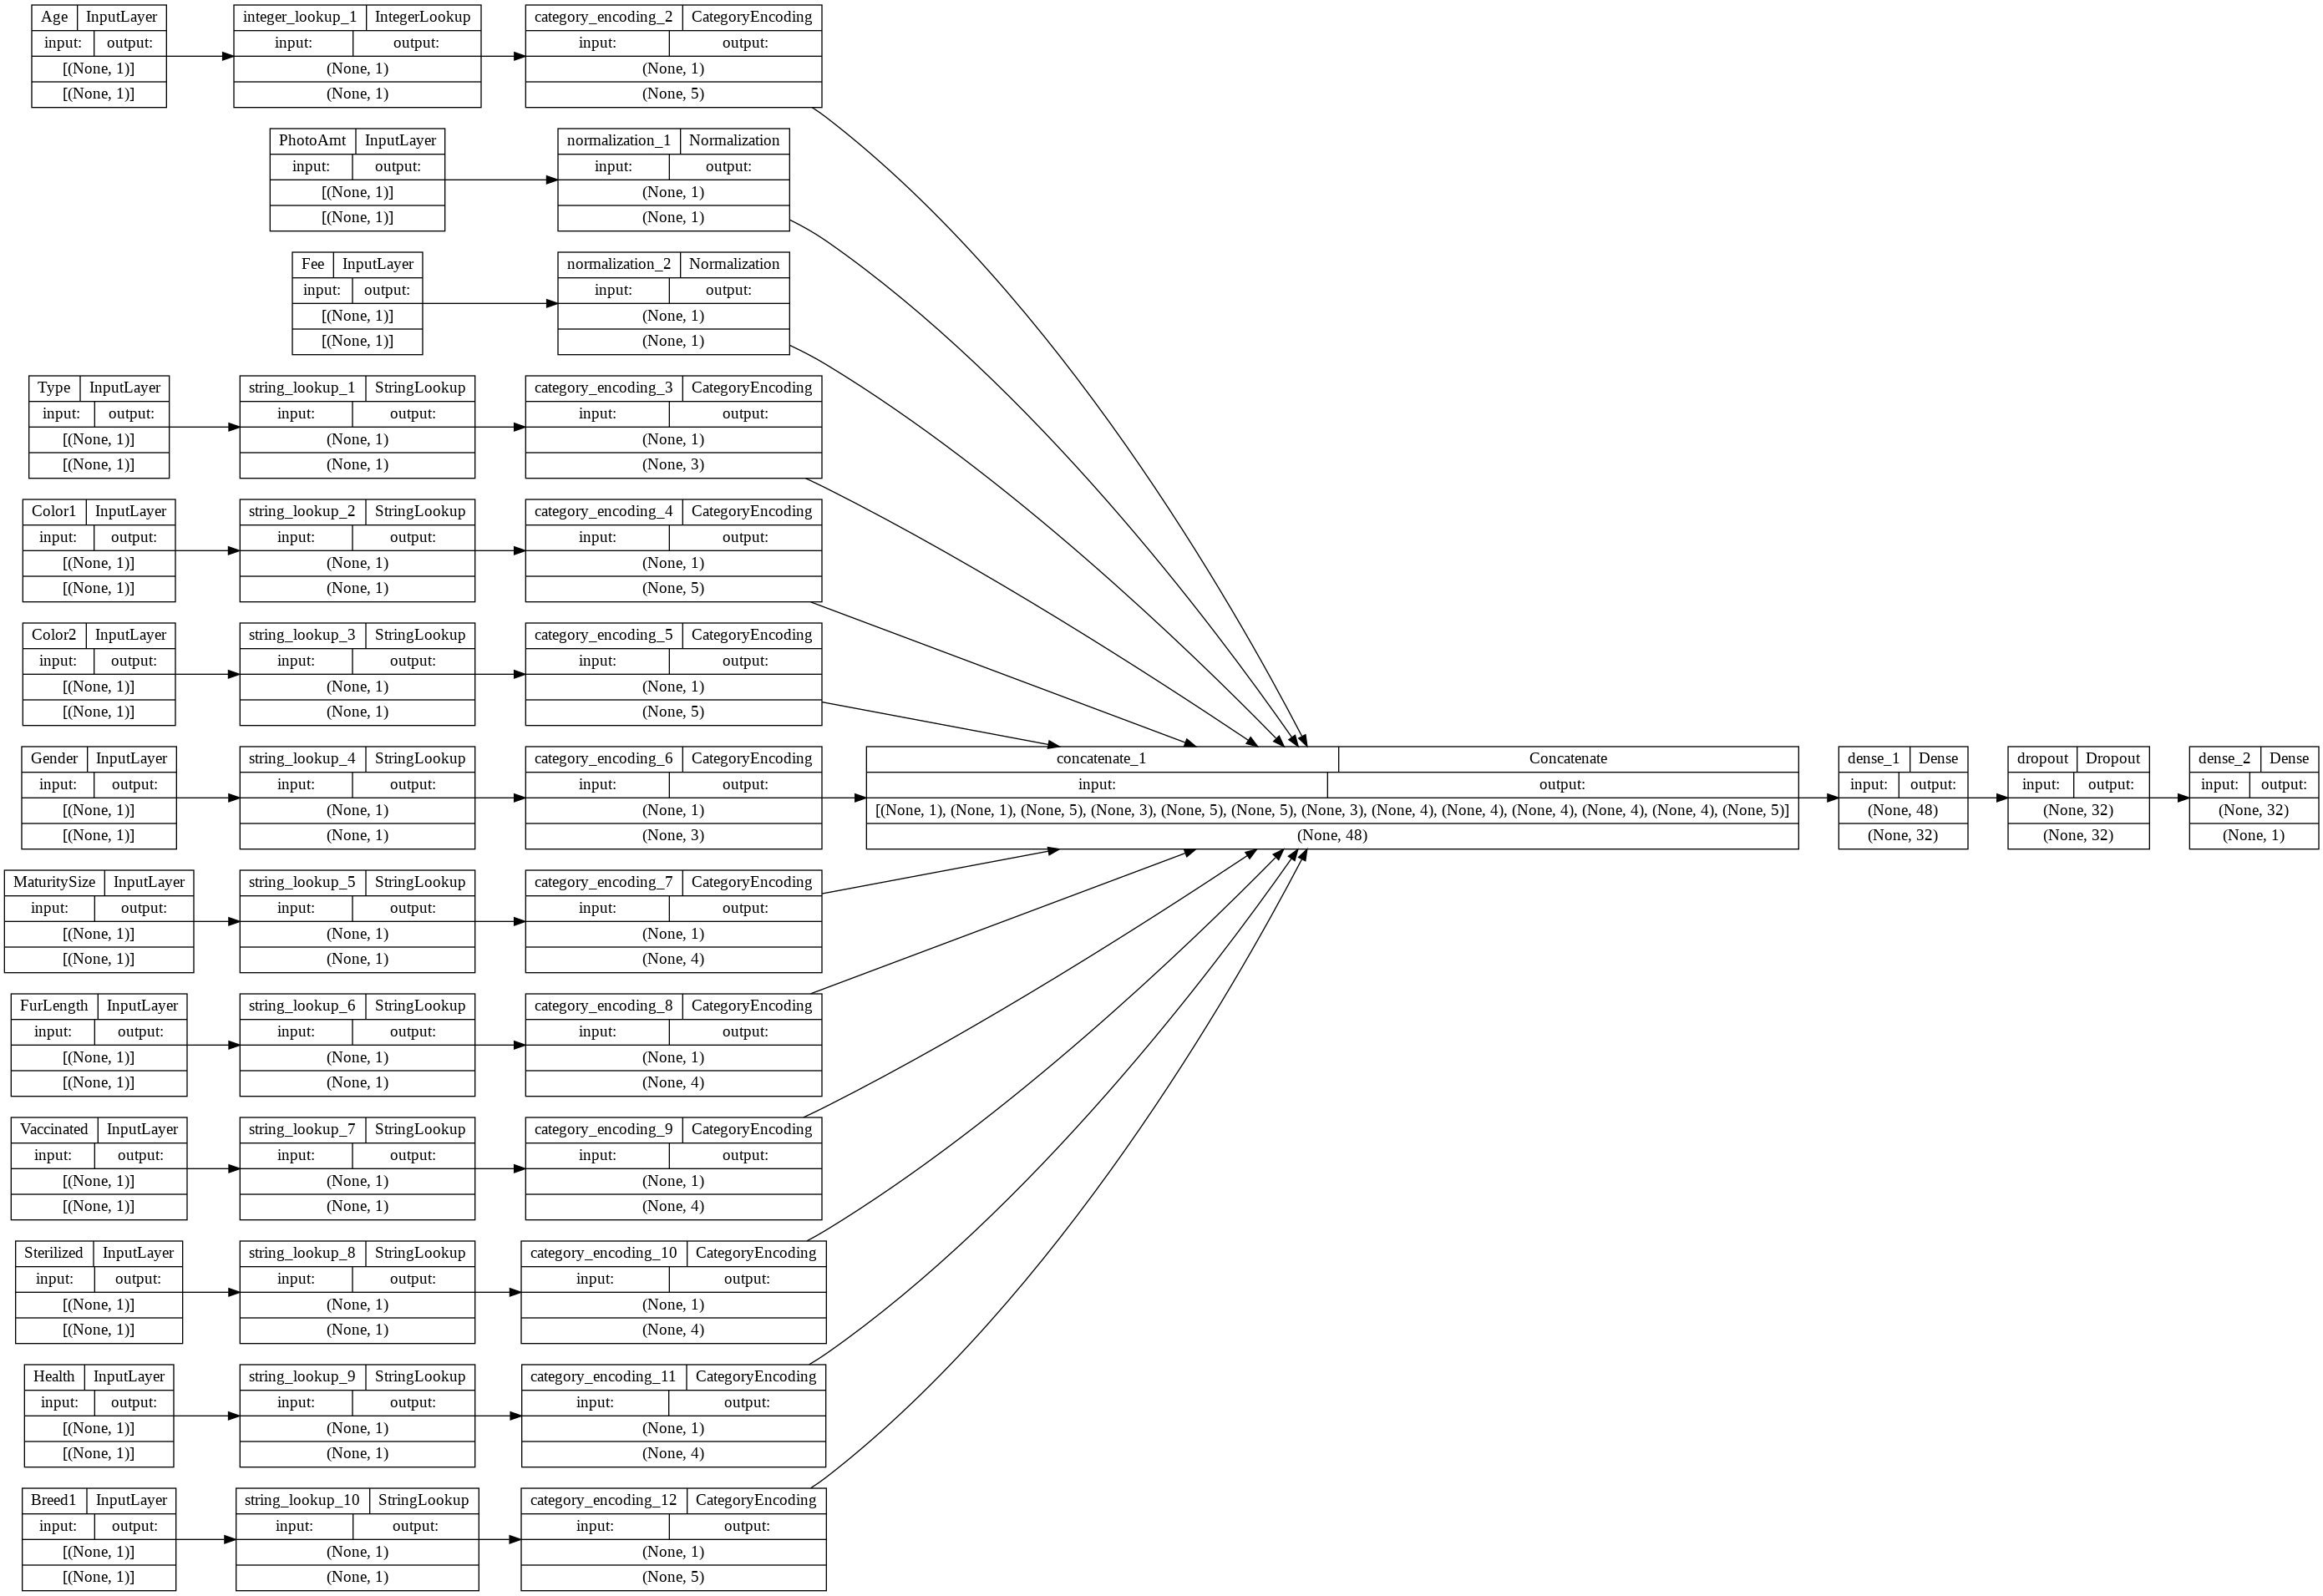

In [ ]:
#Use randir='LR' to make the graph horizontal 
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Następnie szkolę i testuję model

In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 4s 44ms/step - loss: 0.6944 - accuracy: 0.4771 - val_loss: 0.5893 - val_accuracy: 0.6828
Epoch 2/10
37/37 [==============================] - 0s 9ms/step - loss: 0.6090 - accuracy: 0.6396 - val_loss: 0.5619 - val_accuracy: 0.7158
Epoch 3/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5835 - accuracy: 0.6637 - val_loss: 0.5450 - val_accuracy: 0.7305
Epoch 4/10
37/37 [==============================] - 0s 9ms/step - loss: 0.5628 - accuracy: 0.6845 - val_loss: 0.5332 - val_accuracy: 0.7478
Epoch 5/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5481 - accuracy: 0.7015 - val_loss: 0.5239 - val_accuracy: 0.7470
Epoch 6/10
37/37 [==============================] - 0s 9ms/step - loss: 0.5430 - accuracy: 0.7137 - val_loss: 0.5194 - val_accuracy: 0.7478
Epoch 7/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5345 - accuracy: 0.7168 - val_loss: 0.5162 - val_accuracy: 0.7461
Epoch 8/10
37/37 [============

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 7ms/step - loss: 0.5249 - accuracy: 0.7331
Accuracy 0.7331022620201111


**Wnioskowanie**

Opracowany model może teraz klasyfikować wiersz z pliku CSV bezpośrednio po dołączeniu warsrtw przetwarznia wstępnego do samego modelu. 

Mogę teraz zapisać i ponownie wczytać model Keras za pomocą Model.save i Model.load_model przed wykonaniem wnioskowania na nowych danych:

In [ ]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


Aby uzyskać prognozę dla nowej próbki wystarczy wywołać metodę Keras Model.predict. Muszę jednak najpierw:
1. Zawinąć wartości skalarne w listę, aby mieć wymiar partii (Model przetwarza tylko partie danych, a nie pojedynce próbki 
2. Wywołaj tf.convert_to_tensor dla każdej funkcji

In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability of getting adopted." % (100 * prob)
)

This particular pet had a 79.5 percent probability of getting adopted.
